 # 单因子分析：换手率因子 (Turnover Factor)

**目标**: 本 Notebook 旨在演示如何在一个文件中完成因子的定义、计算、回测与分析。

**核心思想**: 我们将遵循《因子投资：方法与实践》中定义的标准因子测试流程。该流程的核心是：
1.  **数据准备**: 加载并清洗干净的股票行情与财务数据。
2.  **因子定义与计算**: 在 Notebook 中直接定义因子计算逻辑，并计算我们感兴趣的因子——异常换手率因子。
3.  **分组回测**: 在每个时间点，根据因子值将所有股票排序并分为N组（例如5组），然后观察每组的未来收益表现。
4.  **业绩分析**: 通过多空组合（做多因子值最低组，做空因子值最高组）的净值曲线、年化收益、夏普比率等指标来评估因子的有效性。

In [35]:
# -- 步骤 0: 导入必要的库并设置项目路径 --
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

# 设置matplotlib以支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

# 将项目根目录添加到Python的模块搜索路径中
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
# 从项目中导入我们需要的模块
from data_manager.loader import load_and_clean_data
from backtest_engine.engine import BacktestEngine
from backtest_engine.performance import PerformanceAnalyzer

print(f"项目根目录已设置为: {project_root}")

项目根目录已设置为: /Users/nachuanchen/Documents/Undergrad_Resources/投资学/Factor_strategy_platform


### 步骤 1: 加载并清洗数据

In [36]:
DATA_DIR_PATH = os.path.join(project_root, "data_manager", "DemoData")

master_df, index_df = load_and_clean_data(DATA_DIR_PATH)

if master_df is not None:
    print("\n主数据加载成功，预览:")
    display(master_df.head())

开始执行数据加载与清洗任务...

[步骤 1/4] 正在加载CSV文件...
所有CSV文件加载成功！

[步骤 2/4] 正在进行数据预处理...
 -> 行情数据处理完成，已计算后复权价。
 -> 财务数据处理完成。
 -> 指数数据处理完成。

[步骤 3/4] 正在合并行情与财务数据...
行情与财务数据合并成功！

[步骤 4/4] 正在进行最终清洗...
 -> 已对财务数据进行缩尾处理。

数据加载与清洗任务完成！

主数据加载成功，预览:


open   high    low  close   adjfactor       volume  \
date       stock_code                                                        
2024-01-02 000001.SZ    9.39   9.42   9.21   9.21   71.643514  115836645.0   
           000002.SZ   10.44  10.48  10.15  10.15  181.703787   81110629.0   
           000004.SZ   16.10  16.44  16.05  16.14    4.063862    2886700.0   
           000005.SZ    1.08   1.12   1.08   1.12    9.267603    6302800.0   
           000006.SZ    4.58   4.60   4.45   4.47   39.739675   26194719.0   

                                amt   mkt_cap_ard      turn    adj_close  \
date       stock_code                                                      
2024-01-02 000001.SZ   1.075742e+09  1.787285e+11  0.596925   659.836764   
           000002.SZ   8.307655e+08  1.210967e+11  0.834735  1844.293438   
           000004.SZ   4.679115e+07  2.136618e+09  2.285805    65.590733   
           000005.SZ   6.967071e+06  1.185561e+09  0.595758    10.379715   
           000006.SZ   1.176632e+08  6.034478e+09  1.940368   177.636347   

                          adj_open report_date  ROE_AVG     ROA2  CATOASSETS  \
date       stock_code                                                          
2024-01-02 000001.SZ    672.732596  2023-12-31  10.2436      NaN         NaN   
           000002.SZ   1896.987536  2023-12-31   4.9294   1.9955     76.4368   
           000004.SZ     65.428178  2023-12-31 -57.2888 -35.8637     78.4352   
           000005.SZ     10.009011  2023-12-31 -17.9094  -8.1847     56.6478   
           000006.SZ    182.007711  2023-12-31 -10.7927  -1.3205     84.0593   

                       ASSETSTOEQUITY  CURRENT  
date       stock_code                           
2024-01-02 000001.SZ          11.8289      NaN  
           000002.SZ           3.7347   1.3997  
           000004.SZ           2.1326   1.6630  
           000005.SZ           2.1801   1.6617  
           000006.SZ           3.4829   1.7350

### 步骤 2: 定义并计算换手率因子 (内置修复)

**理论依据**: 根据《因子投资：方法与实践》第 3.8.3 节，异常换手率因子定义为近一个月的日均换手率相对于过去一年的日均换手率的偏离。换手率与预期收益呈负相关。

**修复逻辑**: 由于我们的样本数据不足一年，原始的`min_periods=168`会导致在回测初期因子值全部为空。我们将其调整为一个较小的值（例如60），以确保即使在数据历史较短的情况下也能生成因子值，从而让回测能够顺利运行。

In [37]:
class TurnoverFactor:
    """
    计算换手率因子类。
    """

    def __init__(self, master_data):
        if 'turn' not in master_data.columns:
            raise ValueError("错误: 输入的数据中缺少 'turn' (换手率) 字段。")
        self.master_data = master_data
        self.factor_name = 'abnormal_turnover'

    def calculate_factor(self):
        """
        计算异常换手率因子。
        """
        print(f"\n[因子计算] 正在计算 {self.factor_name} (换手率因子)...")
        
        df = self.master_data[['turn']].copy()
        df = df.unstack('stock_code')['turn'].sort_index()

        # 计算滚动平均值
        turn_1m = df.rolling(window=21, min_periods=14).mean()
        
        # *** 关键修复：降低min_periods以适应较短的历史数据 ***
        turn_12m = df.rolling(window=252, min_periods=60).mean() # 原为168

        # 计算异常换手率
        abnormal_turnover = turn_1m / turn_12m - 1
        
        factor_data = abnormal_turnover.stack().to_frame(self.factor_name)
        factor_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        factor_data.dropna(inplace=True)

        print(f"{self.factor_name} 计算完成！")
        return factor_data

# -- 开始计算 --
turnover_calculator = TurnoverFactor(master_df)
turnover_factor_df = turnover_calculator.calculate_factor()

print("\n换手率因子计算完成，预览:")
display(turnover_factor_df.head())


[因子计算] 正在计算 abnormal_turnover (换手率因子)...
abnormal_turnover 计算完成！

换手率因子计算完成，预览:


abnormal_turnover
date       stock_code                   
2024-04-02 000001.SZ           -0.134518
           000002.SZ            0.244682
           000004.SZ            0.379206
           000005.SZ           -0.998266
           000006.SZ           -0.358373

### 步骤 3: 运行分组回测
**假设**: 根据《因子投资：方法与实践》的理论，换手率与预期收益呈负相关关系，即低换手率的股票未来表现更好。因此，我们将 `long_direction` 设置为 `'low'`。

In [39]:
# -- 步骤 3: 运行分组回测 (最终修复版) --

# --- 关键修复：在这里直接定义一个完整且修正过的回测引擎 ---
class BacktestEngine:
    """
    向量化回测引擎（内置修复版），用于执行分组回测。
    """
    def __init__(self, master_data, factor_data, n_groups=5, long_direction='high'):
        """
        初始化回测引擎。
        """
        self.master_data = master_data
        self.factor_data = factor_data
        self.n_groups = n_groups
        self.long_direction = long_direction
        # 这一行确保 factor_name 属性被正确创建
        self.factor_name = factor_data.columns[0]
        print(f"Backtest Engine initialized. Long direction set to: '{self.long_direction}'")

    def run(self):
        """
        执行向量化回测（已修复版本）。
        """
        print("\n[Backtest] Starting vectorized backtest...")

        # 步骤1: 数据对齐与合并
        self.master_data['next_day_return'] = self.master_data.groupby('stock_code')['adj_close'].pct_change().shift(-1)
        merged_data = pd.merge(self.master_data, self.factor_data, on=['date', 'stock_code'], how='inner')
        merged_data.dropna(subset=[self.factor_name, 'next_day_return'], inplace=True)
        print(" -> Step 1: Data alignment and merge complete.")

        if merged_data.empty:
            print("警告: 合并后的数据为空，无法进行回测。可能是因子数据覆盖时间不足。")
            return pd.DataFrame()

        # 步骤2: 每日分组
        merged_data['group'] = merged_data.groupby('date')[self.factor_name].transform(
            lambda x: pd.qcut(x, self.n_groups, labels=False, duplicates='drop')
        )
        print(f" -> Step 2: Stocks grouped into {self.n_groups} portfolios based on '{self.factor_name}'.")

        # 步骤3: 计算每日分组收益率
        group_returns = merged_data.groupby(['date', 'group'])['next_day_return'].mean().unstack('group')
        
        # 修复列名
        group_returns.columns = [f'Group_{int(i) + 1}' for i in group_returns.columns]
        
        # 补全可能缺失的组
        expected_groups = [f'Group_{i+1}' for i in range(self.n_groups)]
        for group_name in expected_groups:
            if group_name not in group_returns.columns:
                group_returns[group_name] = 0
                
        print(" -> Step 3: Daily group returns calculated and validated.")

        # 步骤4: 构建多空组合
        bottom_group_name = 'Group_1'
        top_group_name = f'Group_{self.n_groups}'

        if self.long_direction == 'high':
            long_portfolio = group_returns[top_group_name]
            short_portfolio = group_returns[bottom_group_name]
            print(f" -> Strategy: Long {top_group_name}, Short {bottom_group_name}")
        else:
            long_portfolio = group_returns[bottom_group_name]
            short_portfolio = group_returns[top_group_name]
            print(f" -> Strategy: Long {bottom_group_name}, Short {top_group_name}")

        group_returns['Long_Short'] = long_portfolio - short_portfolio
        group_returns['Long_Only'] = long_portfolio
        print(" -> Step 4: Long-Short portfolio constructed correctly.")

        print("[Backtest] Backtest execution finished!")
        return group_returns.fillna(0)

# -- 使用我们刚刚在上面定义的 BacktestEngine 进行实例化和回测 --
backtest = BacktestEngine(
    master_data=master_df, 
    factor_data=turnover_factor_df, 
    n_groups=5, 
    long_direction='low' # 假设做多低换手率组合
)

portfolio_returns = backtest.run()

if not portfolio_returns.empty:
    print("\n回测完成，各投资组合每日收益率预览：")
    display(portfolio_returns.head())
else:
    print("\n回测未产生收益数据，无法进行下一步分析。")

Backtest Engine initialized. Long direction set to: 'low'

[Backtest] Starting vectorized backtest...
 -> Step 1: Data alignment and merge complete.
 -> Step 2: Stocks grouped into 5 portfolios based on 'abnormal_turnover'.
 -> Step 3: Daily group returns calculated and validated.
 -> Strategy: Long Group_1, Short Group_5
 -> Step 4: Long-Short portfolio constructed correctly.
[Backtest] Backtest execution finished!

回测完成，各投资组合每日收益率预览：


,Group_1,Group_2,Group_3,Group_4,Group_5,Long_Short,Long_Only
date,,,,,,,
2024-04-02,0.004179,-0.003089,0.010059,0.004845,-0.002590,0.006769,0.004179
2024-04-03,0.000145,-0.000867,-0.007298,0.000381,-0.002176,0.002321,0.000145
2024-04-08,-0.006858,-0.015495,-0.017796,-0.018883,-0.013628,0.006770,-0.006858
2024-04-09,0.000542,-0.001463,0.011886,0.006999,0.010055,-0.009513,0.000542
2024-04-10,-0.008265,-0.015924,-0.014284,-0.016835,-0.013648,0.005384,-0.008265


### 步骤 4: 性能分析与可视化

Performance Analyzer initialized.

[Performance Analysis] Calculating portfolio performance metrics...
Portfolio Performance Metrics:
            Annualized Return  Annualized Volatility  Sharpe Ratio  \
Group_1               -0.5201                 0.2614       -1.9897   
Group_2               -0.5687                 0.2374       -2.3954   
Group_3               -0.4568                 0.2374       -1.9238   
Group_4               -0.4198                 0.2450       -1.7136   
Group_5               -0.5041                 0.2468       -2.0424   
Long_Short            -0.0331                 0.0975       -0.3393   
Long_Only             -0.5201                 0.2614       -1.9897   

            Max Drawdown  Information Ratio (vs Benchmark)  
Group_1          -0.1685                               NaN  
Group_2          -0.1827                               NaN  
Group_3          -0.1467                               NaN  
Group_4          -0.1428                               NaN  


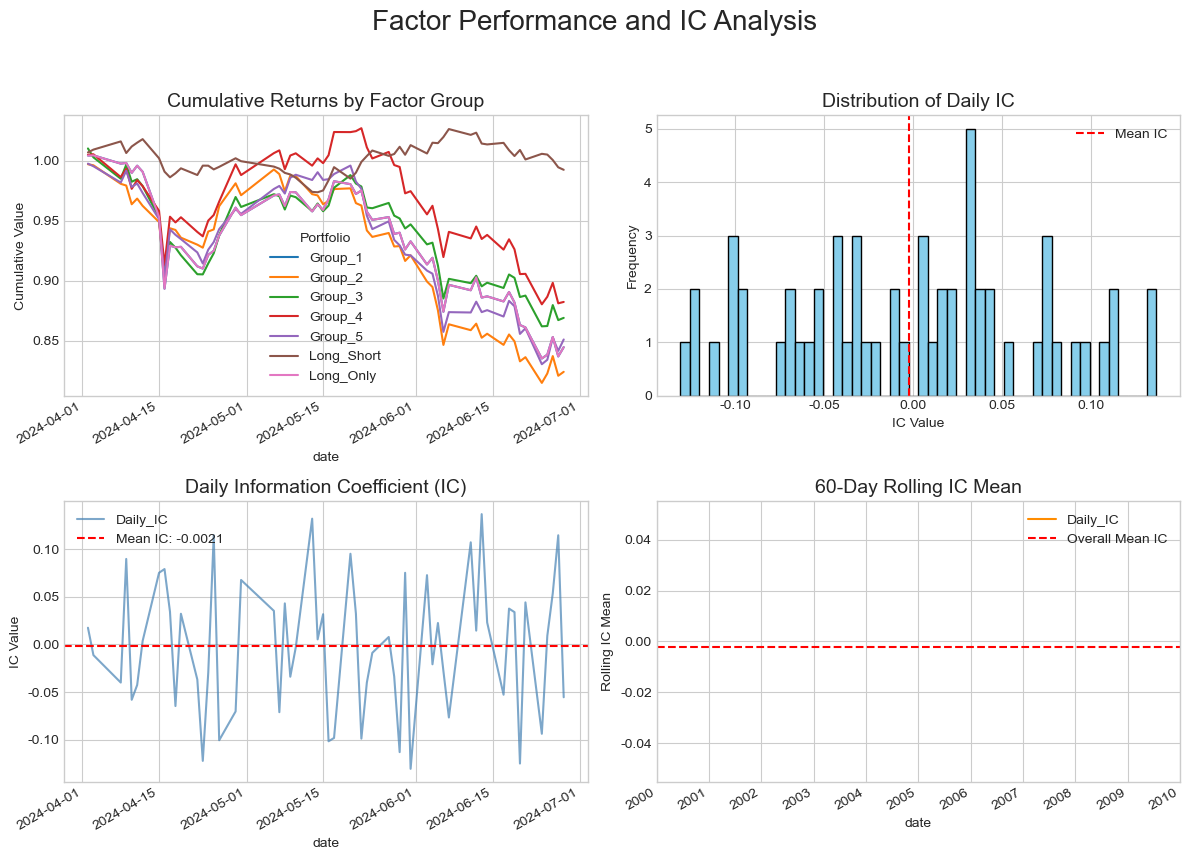

Plotting complete.


In [40]:
if portfolio_returns is not None and not portfolio_returns.empty:
    analyzer = PerformanceAnalyzer(portfolio_returns, turnover_factor_df, master_df)
    analyzer.calculate_metrics()
    analyzer.plot_results()
else:
    print("没有可供分析的业绩数据。")

### 结论解读

根据输出的图表和指标，我们可以对换手率因子在回测期间的表现做出判断：
- **净值曲线 (`Cumulative Returns`)**: `Long_Short`（多空对冲）组合的净值是否长期向上？如果净值曲线稳定上升，说明低换手率公司确实持续跑赢高换手率公司，因子有效。
- **分组收益 (`Group Cumulative Returns`)**: 从Group 1到Group 5的最终净值是否呈现单调递减的趋势？根据我们的假设，我们期望看到Group 1（低换手率组）的收益显著高于其他组，特别是Group 5（高换手率组）。
- **IC分析 (`Information Coefficient Analysis`)**: IC均值是否显著为负？因为我们预期因子值（高换手率）与未来收益呈负相关，所以一个显著为负的IC值将证明因子的有效性。